In [1]:
import os
from pathlib import Path
from pydantic import BaseSettings
from matplotlib import  pyplot as plt

import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

In [2]:
class StatsConfig(BaseSettings):
    class Config:
        env_file = ".env"
        env_file_encoding = "utf-8"
    data_processed: Path
    subset: str = "train"

In [3]:
cwd = Path(os.getcwd())
os.chdir(str(cwd.parent))
print(os.getcwd())

/home/montello/works/ermes/flood-delineation/src/flood-segmentation


In [4]:
cfg = StatsConfig()
cfg

StatsConfig(data_processed=PosixPath('/mnt/userdata/montello_data/shub/imgs_zoom11/ready-to-train'), subset='train')

In [5]:
from floods.datasets.flood import FloodDataset
from floods.prepare import train_transforms_base, train_transforms_dem, train_transforms_sar, eval_transforms, inverse_transform
from floods.utils.gis import rgb_ratio

In [6]:
mean = FloodDataset.mean()
std = FloodDataset.std()
clip_min = FloodDataset.clip_min()
clip_max = FloodDataset.clip_max()

base_trf = train_transforms_base(image_size=512)
sar_trf = train_transforms_sar()
dem_trf = train_transforms_dem(0)
normalize = eval_transforms(mean=mean,
                            std=std,
                            clip_min=clip_min,
                            clip_max=clip_max)
# create train and validation sets
dataset = FloodDataset(path=cfg.data_processed,
                       subset="train",
                       include_dem=True,
                       transform_base=base_trf,
                       transform_sar=sar_trf,
                       transform_dem=dem_trf,
                       normalization=normalize)
loader = DataLoader(dataset, batch_size=2, num_workers=4, pin_memory=True, shuffle=False)
invert = inverse_transform(mean=FloodDataset.mean(), std=FloodDataset.std())

In [7]:
indices = np.random.choice(len(loader), size=5, replace=False)
indices = [0, 1, 2, 3, 4]


0it [00:00, ?it/s]

vv 0.029655874 1.0
vh 0.019451052 1.0


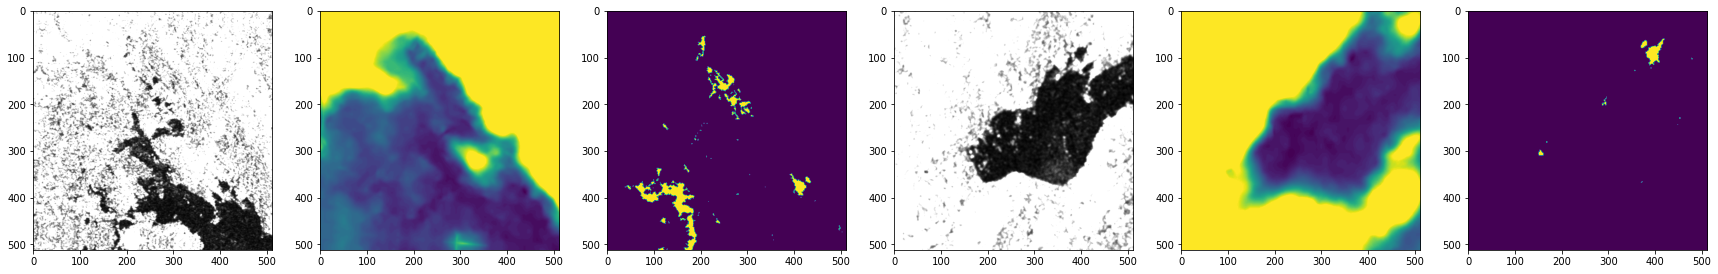

1it [00:06,  6.10s/it]

vv 0.018612146 7.621796
vh 0.018536001 2.0463536


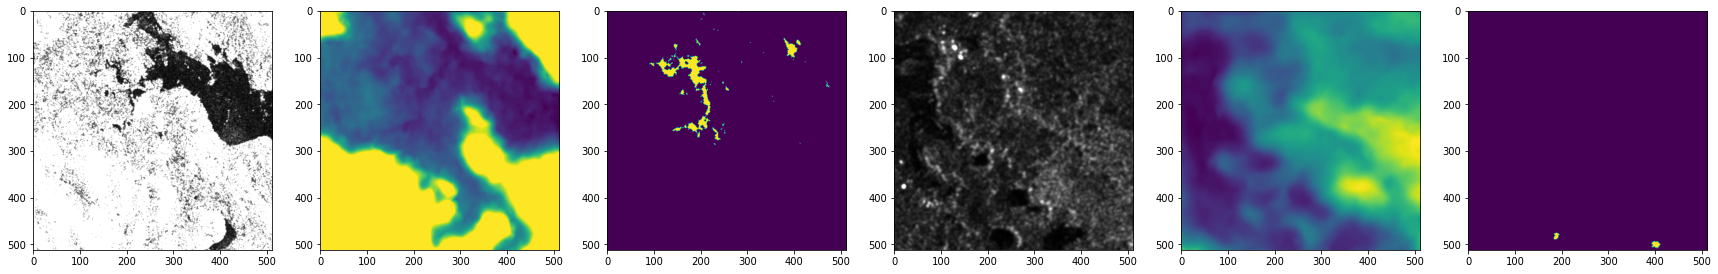

2it [00:06,  2.97s/it]

vv 0.034694493 7.621796
vh 0.02786753 2.0463536


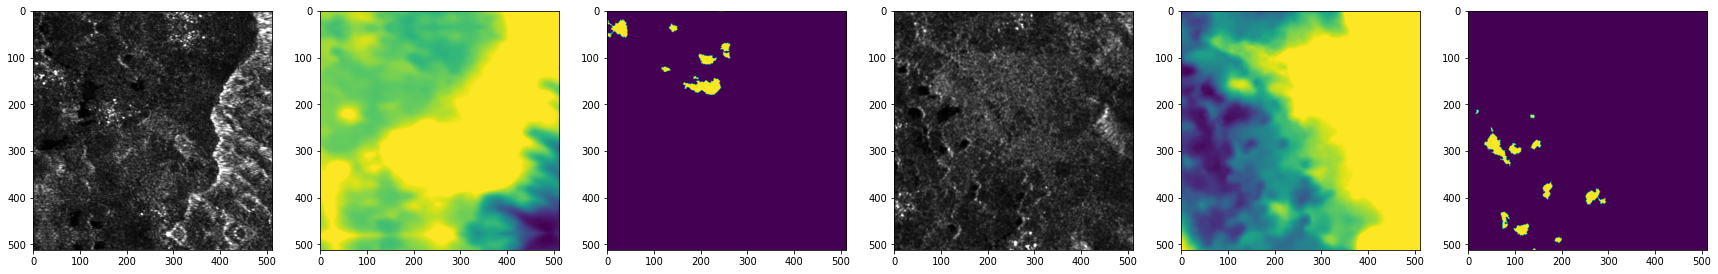

3it [00:07,  1.97s/it]

vv 0.059850395 7.621796
vh 0.042666413 2.0463536


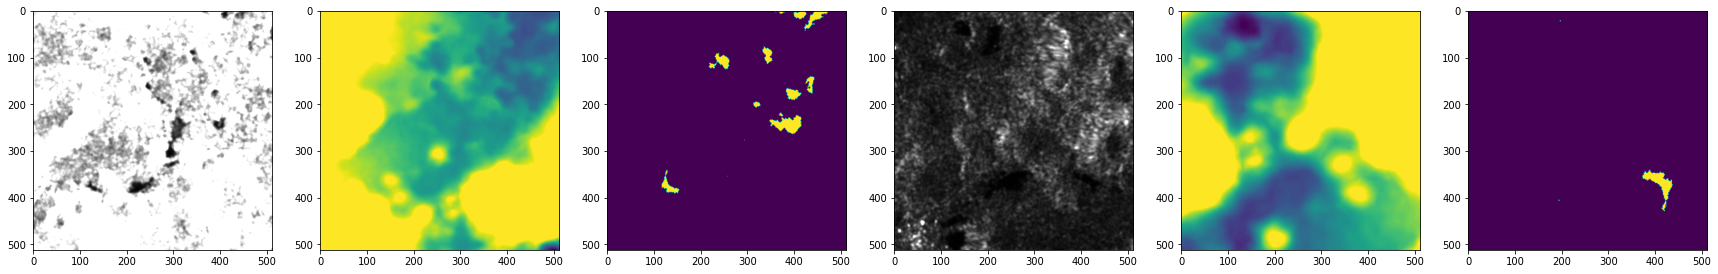

4it [00:08,  1.55s/it]

vv 0.027397722 1.0
vh 0.019328326 1.0


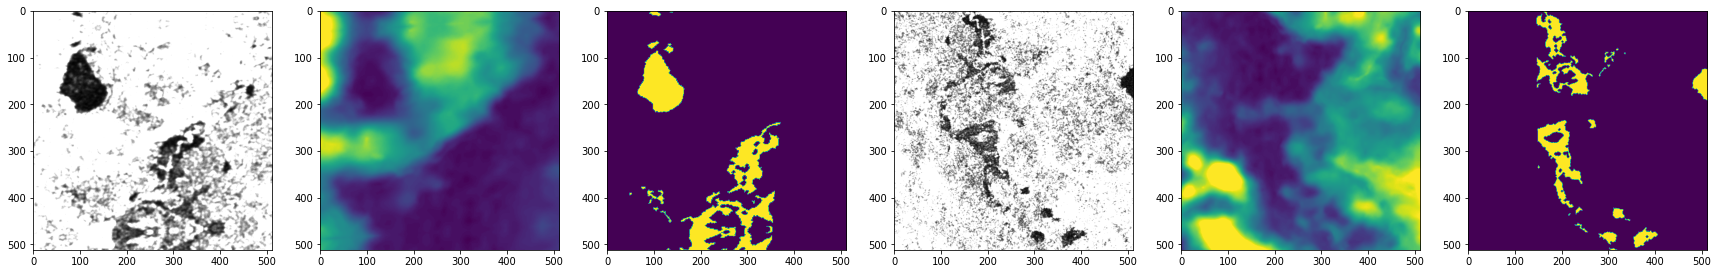

4it [00:09,  2.35s/it]


In [8]:
for i, (images, label) in tqdm(enumerate(loader)):
    if i not in indices:
        continue
    else:
        
        images = invert(images)
        f, axes = plt.subplots(1, 6, figsize=(30, 10))
        print('vv', images[:,:,:,0].min(), images[:,:,:,0].max())
        print('vh', images[:,:,:,1].min(), images[:,:,:,1].max())
        for j in range(images.shape[0]):
            # rgb = rgb_ratio(images[j], weights=(0.6, 1.1, 0.005))
            axes[j * 3].imshow(images[j, :, :,0]/images[:,:,:,0].max(), cmap="gray")
            axes[j * 3 + 1].imshow(images[j][:,:,-1])
            axes[j * 3 + 2].imshow(label[j])
        plt.show()
    if(i == 4):
        break

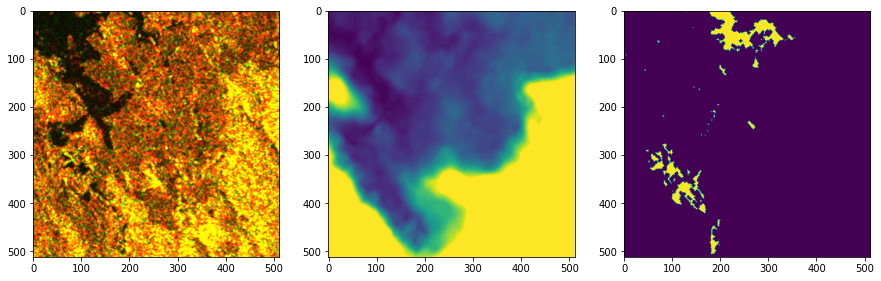

In [9]:
images, label = dataset.__getitem__(0)
images = invert(images)

f, axes = plt.subplots(1, 3, figsize=(15, 5))
rgb = rgb_ratio(images, weights=(0.6, 1.1, 0.005))
axes[0].imshow(rgb)
axes[ 1].imshow(images[:,:,-1])
axes[2].imshow(label)
plt.show()